# Semantic Segmentation

Semantic segmentation, or image segmentation, is the task of clustering parts of an image together which belong to the same object class. In this tutorial, we will...

## Part 1

1. Learn about the [DynamicEarthNet Challenge](#1.-DynamicEarthNet-Challenge),
2. Meet the [data](#2.-DynamicEarthNet:-Daily-Multi-Spectral-Satellite-Dataset-for-Semantic-Change-Segmentation),
3. Explore a [random forest-based segmentation model](#3.-Random-Forest)
4. Design a simple [convolutional neural network-based solution](#4.-Simple-CNN-based-approach)

## Part 2

5. Use a [U-Net](#5.-The-U-Net) to segment the images,
6. Load a [pre-trained models](#6.-Pre-trained-weights), and
7. Improve the performance with transfer-learning.

# Part 1

## 1. DynamicEarthNet Challenge

Remote sensing is entering a new era of time-series analysis. Short revisit times of satellites allow for monitoring of many areas across the globe on a weekly basis. However, there has been little exploration of deep learning techniques to leverage this new temporal dimension at scale. Especially, existing approaches have struggled to combine the power of different sensors to make use of all available information. In addition, large scale high quality change detection benchmarks are rare. To stimulate innovation in spatio-temporal machine learning, we have partnered up to propose a unique challenge centered around modeling multi-temporal land cover changes from Planetscope and Sentinel time series data.

Do you want to know more? Then, visit the [DynamicEarthNet](https://codalab.lisn.upsaclay.fr/competitions/2882) web page!

![Data sample](challenge_sample_cube.gif)

## 2. DynamicEarthNet: Daily Multi-Spectral Satellite Dataset for Semantic Change Segmentation

**#TODO** Add a description

More details can be found in the original [data set paper](https://openaccess.thecvf.com/content/CVPR2022/papers/Toker_DynamicEarthNet_Daily_Multi-Spectral_Satellite_Dataset_for_Semantic_Change_Segmentation_CVPR_2022_paper.pdf).

```
@inproceedings{toker2022dynamicearthnet,
  title={DynamicEarthNet: Daily Multi-Spectral Satellite Dataset for Semantic Change Segmentation},
  author={Toker, Aysim and Kondmann, Lukas and Weber, Mark and Eisenberger, Marvin and Camero, Andr{\'e}s and Hu, Jingliang and Hoderlein, Ariadna Pregel and {\c{S}}enaras, {\c{C}}a{\u{g}}lar and Davis, Timothy and Cremers, Daniel and others},
  booktitle={Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition},
  pages={21158--21167},
  year={2022}
}

```

In [ ]:
# install the required packages using pip install -r requirements.txt
# import sys
# !{sys.executable} -m pip install -r requirements.txt

In [ ]:
import h5py
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from functools import reduce

np.random.seed(3108)

In [ ]:
# this should match the name of the data sets
filename = 'data/dynamic_earth_net.h5'

dataset = h5py.File(filename, 'r')

# show the content names
print(list(dataset.keys()))

In [ ]:
# load Sentinel-2 data
# O'Brien Mountain, California, US. 
# Check it on [Google Maps](https://goo.gl/maps/FwK3my9AX1xZ2Jrs5)
sen2_train = np.array(dataset['s2_train'])

print("Sentinel-2 shape: ", sen2_train.shape)
# 24 samples, 1024x1024 pixels, 12 bands

def true_color(X):
    blue = ((X[:,:,0] - np.min(X[:,:,0])) / (np.max(X[:,:,0]) - np.min(X[:,:,0])))
    green = ((X[:,:,1] - np.min(X[:,:,1])) / (np.max(X[:,:,1]) - np.min(X[:,:,1])))
    red = ((X[:,:,2] - np.min(X[:,:,2])) / (np.max(X[:,:,2]) - np.min(X[:,:,2])))
    return np.dstack((red, green, blue))  

index = 2

fig=plt.figure(figsize=(12, 12))
# B2 = blue, B3 = green, and B4 = red. Note that B1 (coastal aerosol) was not
# included in the data set. 
# More info at https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/
plt.imshow(true_color(sen2_train[index]))
plt.title('Sentinel-2')
plt.show()

In [ ]:
# load Planet Fusion data
planet_train = np.array(dataset['planet_train'])

print("Planet Fusion shape: ", planet_train.shape)
# 24 samples, 1024x1024 pixels, 4 bands

index = 2

fig=plt.figure(figsize=(12, 12))
# B1 = blue, B2 = green, B3 = red, and B4= NIR
plt.imshow(true_color(planet_train[index]))
plt.title('Planet Scope')
plt.show()

In [ ]:
# Ocala area, Florida, US. You can check it on [Google Maps](https://goo.gl/maps/uXmmcdaniRDiQEqA6)
sen2_test = np.array(dataset['s2_test'])
planet_test = np.array(dataset['planet_test'])

fig=plt.figure(figsize=(12, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(true_color(sen2_test[index]))
plt.title('Sentinel-2')
fig.add_subplot(1, 2, 2)
plt.imshow(true_color(planet_test[index]))
plt.title('Planet ScopeEOC VPN')
plt.show()

In [ ]:
# load Planet Fusion data
labels_train = np.array(dataset['labels_train'])
labels_test = np.array(dataset['labels_test'])

print("Labels shape: ", labels_train.shape)
# 24 samples, 1024x1024 pixels, 12 bands

color_map = cm.get_cmap("Accent", lut=labels_train.shape[-1])
labels=['impervious surface',
       'agriculture',
       'forest & other vegetation',
       'wetlands',
       'soil',
       'water',
       'snow & ice']

def labels2rgb(
    X,
    colors=color_map.colors):
    Z = np.zeros((X.shape[0], X.shape[1], 3))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = colors[np.argmax(X[i,j]), :3]
    return Z

fig=plt.figure(figsize=(12, 12))
plt.imshow(labels2rgb(labels_train[index]), cmap=color_map)
plt.title('Labels')
cbar = plt.colorbar(ticks=np.linspace(1/14, 13/14, 7))
cbar.set_ticklabels(labels)
plt.show()

In [ ]:
fig=plt.figure(figsize=(12, 12))
plt.imshow(labels2rgb(labels_test[index]), cmap=color_map)
plt.title('Labels')
cbar = plt.colorbar(ticks=np.linspace(1/14, 13/14, 7))
cbar.set_ticklabels(labels)
plt.show()

One key application of our dataset is to measure how a given local region changes over time. For the standard task of binary change detection, we classify each pixel into change or no-change. This definition, however, disregards semantic information. We, therefore, generalize this classical notion to a multi-class segmentation task, which we refer to as semantic change segmentation.

In [ ]:
fig=plt.figure(figsize=(12, 12))

for i in range(2,6):
    fig.add_subplot(2, 2, i-1)
    plt.imshow(labels2rgb(labels_train[i]), cmap=color_map)

plt.show()

## 3. Random Forest Segmenter

Let's start with a very simple approach, namely using a *Random Forest Classifier* to segment an image. Loosely speaking, we will "classify" each pixel into one of the semantic segmentation categories.

In [ ]:
def labels2int(X):
    Z = np.zeros(X.shape[:3])    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            for k in range(X.shape[2]):
                Z[i,j,k] = np.argmax(X[i,j,k,:]) + 1
    return Z

labels_train_int = labels2int(labels_train)

We now need to format the data so that it fits to what the random forest classifier expects, namely an array of shape (n, m) as input data, and (n) annotations. Note that n corresponds to number of pixels and m to number of features (in our case, bands or channels).

In [ ]:
y = np.reshape(labels_train_int[0], 
                                   (reduce(lambda x, y: x*y, labels_train_int[0].shape)))
print("Labels flattened shape", y.shape)

X = np.reshape(planet_train[0], (reduce(lambda x, y: x*y, planet_train[0].shape[:-1]),
                                              reduce(lambda x, y: x*y, planet_train[0].shape[-1:])))
print("Train flattened shape", X.shape)

Let's train a *Random Forest Classifier* to segment an image. Note that we are training on a single image.

In [ ]:
rfc = RandomForestClassifier(random_state=3108)
rfc.fit(X, y)

Now, we will use the trained model to segment a new image.

In [ ]:
Z = np.reshape(planet_train[-1], (reduce(lambda x, y: x*y, planet_train[-1].shape[:-1]),
                                              reduce(lambda x, y: x*y, planet_train[-1].shape[-1:])))
yz = rfc.predict(Z)
yz_img = np.reshape(yz.copy(), (labels_train_int[-1].shape[0], labels_train_int[-1].shape[1]))

In [ ]:
# this is just a visualization shortcut, to get the same colors
# particularly, we add the missing classes to get the same color map
gt = labels_train_int[-1].copy()
gt[0,0:len(labels)] = list(range(1,1+len(labels)))
yz_img[0,0:len(labels)] = list(range(1,1+len(labels)))


fig = plt.figure(figsize=(12, 12))

fig.add_subplot(1, 2, 1)
plt.imshow(gt, cmap=color_map)

fig.add_subplot(1, 2, 2)
plt.imshow(yz_img, cmap=color_map)

plt.show()

In [ ]:
gt = labels_train_int[-1].copy()
# gt[0,0:len(labels)] = list(range(1,1+len(labels)))

On the left side, the ground truth is show, while on the right side the predicted segmentation is shown. Qualitatively, the results are quite OK. So, how about a quantitative appraisal?

There are different metrics to evaluate the performance of a semantic segmentation:
1. Pixel accuracy: Is the percent of pixels in your image that are classified correctly.
2. Intersection-Over-Union (IoU, Jaccard Index): The IoU is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth.
3. Dice coefficient (F1 Score): Is two times the area of overlap divided by the total number of pixels in both images.

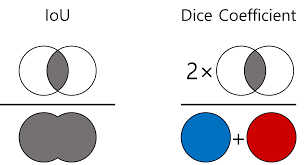

In [ ]:
print("Accuracy: %5.4f" % metrics.accuracy_score(labels_train_int[-1].flatten(), yz))
print("IoU: %5.4f" % metrics.jaccard_score(labels_train_int[-1].flatten(), yz, average="weighted"))
print("F1 Score: %5.4f" % metrics.f1_score(labels_train_int[-1].flatten(), yz, average="weighted"))

Performance is overall quite good (in-line with the qualitative evaluation). However, it is relatively easy to observe that two classes are *predominant* (aka. majority class). What is happening to individual classes?

In [ ]:
print(metrics.f1_score(labels_train_int[-1].flatten(), yz, average=None))

In [ ]:
cm = metrics.confusion_matrix(labels_train_int[-1].flatten(), yz, labels=list(range(1,1+len(labels))))
metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                               display_labels=labels).plot(xticks_rotation="vertical")

## Do it yourself

Train a *Random Forest Classifier* to segment using the test image(s), and compare the performance with respect to the example shown above.

In [ ]:
# prepare the data, i.e., create the X, y and Z by converting the test labels from one-hot to vector, selecting one sample from the test data and flattening it to create the X, 
# and repeat with another sample to create Z

# instanciate a RF classifier

# train the RF on one of the test samples

# predict on a different sample from the test set

# evaluate the performance

## 4. Simple CNN-based approach

We will implement a FCN (fully convolutional network)

In [ ]:
def fcn_model(num_classes=7, dropout_rate=0.2):        
    input = tf.keras.layers.Input(shape=(1024, 1024, 4))

    # A convolution block
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(input)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Fully connected layer 1
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Fully connected layer 2
    x = tf.keras.layers.Conv2D(filters=num_classes, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)    
    
    predictions = tf.keras.layers.Activation('softmax')(x)
    
    model = tf.keras.Model(inputs=input, outputs=predictions)
    
    return model   


In [ ]:
fcn = fcn_model()
print(fcn.summary())

In [ ]:
fcn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
X_fcn = planet_train[0:1]
y_fcn = labels_train[0:1]

In [ ]:
fcn.fit(X_fcn, y_fcn, epochs=5)

In [ ]:
yz_fcn = fcn.predict(planet_train[-1:])
yz_fcn_int = labels2int(yz_fcn)[0]

In [ ]:
yz_fcn_img = yz_fcn_int.copy()
yz_fcn_img[0,0:len(labels)] = list(range(1,1+len(labels)))

fig = plt.figure(figsize=(12, 12))

fig.add_subplot(1, 2, 1)
plt.imshow(gt, cmap=color_map)

fig.add_subplot(1, 2, 2)
plt.imshow(yz_fcn_img, cmap=color_map)

plt.show()

In [ ]:
print("Accuracy: %5.4f" % 
      metrics.accuracy_score(labels_train_int[-1].flatten(), yz_fcn_int.flatten()))
print("IoU: %5.4f" % 
      metrics.jaccard_score(labels_train_int[-1].flatten(), yz_fcn_int.flatten(), average="weighted"))
print("F1 Score: %5.4f" % 
      metrics.f1_score(labels_train_int[-1].flatten(), yz_fcn_int.flatten(), average="weighted"))

In [ ]:
cm_fcn = metrics.confusion_matrix(labels_train_int[-1].flatten(), yz_fcn_int.flatten(), labels=list(range(1,1+len(labels))))
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_fcn, 
                               display_labels=labels).plot(xticks_rotation="vertical")

## Do it yourself

Notice that the input's range differs from one channel to the other (check the `code` block below). Then, standarize or normalize the input, and try the model again.

In [ ]:
plt.hist(X_fcn[:,:,:,2].flatten(), label="red", color="red", alpha=0.8)
plt.hist(X_fcn[:,:,:,1].flatten(), label="green", color="green", alpha=0.8)
plt.hist(X_fcn[:,:,:,0].flatten(), label="blue", color="blue", alpha=0.8)
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.yscale("log")
plt.show()

In [ ]:
# use StandardScaler to pre-process the training and test samples (X and Z). 
# you may check the example at https://github.com/acamero/data-science-eo-regression/blob/main/population_estimation.ipynb


## Do it yourself

Define a new model based on the `fcn_model`, but this time add a new layer. Also, try a different activation function and modify the number of filters.

In [ ]:
# copy/paste the function 'fcn_model', and modify it

# compile and train the model

# predict

# evaluate the performance

## Do it yourself (pro)

Train your new model on the whole training data set, and evaluate the performance of the model on the first image of the test data set.

# Part 2

## 5. The U-Net

The U-Net is convolutional network architecture for fast and precise segmentation of images. It was originally invented, and first used for biomedical image segmentation. Its architecture can be broadly seen as an encoder network followed by a decoder network. Unlike classification, where the end result of the the deep network is the only important thing, semantic segmentation not only requires discrimination at pixel level but also a mechanism to project the discriminative features learnt at different stages of the encoder onto the pixel space.

The *encoder* is usually a pre-trained classification network (e.g., VGG or ResNet) where convolution blocks followed by maxpool downsampling are applied to encode the input image into multiple feature representation spaces.

The *decoder* semantically project the discriminative features (lower resolution) learnt by the encoder onto the pixel space (i.e., higher resolution) to get a dense classification (aka. segmentation).

The following image introduces the U-Net architecture (image taken from [*U-Net: Convolutional Networks for Biomedical Image Segmentation*](https://arxiv.org/abs/1505.04597v1))

![U-Net architecture](u-net-architecture.png)

In [ ]:
def unet_model(num_classes=7,
               input_size=(1024, 1024, 4),
               drop_out=0.5):
    # encoder
    inputs = tf.keras.layers.Input(input_size)
    # maybe try adding kernel_initializer='he_normal'
    # Conv2D( filters, kernel_size, ... )
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = tf.keras.layers.Dropout(drop_out)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = tf.keras.layers.Dropout(drop_out)(conv5)

    # decoder
    up6 = tf.keras.layers.Conv2D(512, 2, activation='relu', padding='same')(
        tf.keras.layers.UpSampling2D(size=(2,2))(drop5))
    merge6 = tf.keras.layers.concatenate([drop4, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2D(256, 2, activation='relu', padding='same')(
        tf.keras.layers.UpSampling2D(size=(2,2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3, up7], axis = 3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.Conv2D(128, 2, activation='relu', padding='same')(
        tf.keras.layers.UpSampling2D(size=(2,2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.Conv2D(64, 2, activation='relu', padding='same')(
        tf.keras.layers.UpSampling2D(size=(2,2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = tf.keras.layers.Conv2D(2, 3, activation='relu', padding='same')(conv9)
    
    conv10 = tf.keras.layers.Conv2D(num_classes, 1, activation='relu')(conv9)
    
    predictions = tf.keras.layers.Activation('sigmoid')(conv10)

    model = tf.keras.Model(inputs=inputs, outputs=predictions)    

    return model

In [ ]:
unet = unet_model()
unet.summary()

In [ ]:
unet.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
unet.fit(X_fcn, y_fcn, epochs=5)

In [ ]:
yz_unet = unet.predict(planet_train[-1:])
yz_unet_int = labels2int(yz_unet)[0]

In [ ]:
yz_unet_img = yz_unet_int.copy()
yz_unet_img[0,0:len(labels)] = list(range(1,1+len(labels)))

fig = plt.figure(figsize=(12, 12))

fig.add_subplot(1, 2, 1)
plt.imshow(gt, cmap=color_map)

fig.add_subplot(1, 2, 2)
plt.imshow(yz_unet_img, cmap=color_map)

plt.show()

In [ ]:
print("Accuracy: %5.4f" % 
      metrics.accuracy_score(labels_train_int[-1].flatten(), yz_unet_int.flatten()))
print("IoU: %5.4f" % 
      metrics.jaccard_score(labels_train_int[-1].flatten(), yz_unet_int.flatten(), average="weighted"))
print("F1 Score: %5.4f" % 
      metrics.f1_score(labels_train_int[-1].flatten(), yz_unet_int.flatten(), average="weighted"))

In [ ]:
cm_unet = metrics.confusion_matrix(labels_train_int[-1].flatten(), yz_unet_int.flatten(), labels=list(range(1,1+len(labels))))

metrics.ConfusionMatrixDisplay(confusion_matrix=cm_unet, 
                               display_labels=labels).plot(xticks_rotation="vertical")

## Do it yourself

Train the model using the standarized or normalized input data. Try to increase the training budget (i.e., the number of epochs), and adjust the *drop out*. Do you see any improvement?

## 6. Pre-trained weights

You may have notice that the U-Net architecture (as define above) has more than 31 million trainable parameters! Therefore, an immense amount of data is needed to train the network (if you want to get a decent performance).

Since we don't have much data, and we want to save time, let's try to reuse a pre-trained model.

What is a pre-trained model? In plain English, it is a model that was trained using a data set, and its weights have been saved. Usually, the data set used to train is *general*, e.g., imagenet.

In [ ]:
def pre_unet_model(input_size=(1024, 1024, 4)):
    # note that we are fixing the number of channels, because the pre-trained model
    # was designed and trained for RGB
    inputs = tf.keras.layers.Input(shape=(input_size[0], input_size[1], 3), name="input_image")
    
    encoder = tf.keras.applications.MobileNetV2(
        input_tensor=inputs, 
        weights="imagenet", 
        include_top=False, 
        alpha=0.35)
    
    skip_connection_names = [
        "input_image", 
        "block_1_expand_relu", 
        "block_3_expand_relu", 
        "block_6_expand_relu"]
    
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
        x = tf.keras.layers.Concatenate()([x, x_skip])
        
        x = tf.keras.layers.Conv2D(f[-i], (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        
        x = tf.keras.layers.Conv2D(f[-i], (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        
    x = tf.keras.layers.Conv2D(7, (1, 1), padding="same")(x)
    x = tf.keras.layers.Activation("sigmoid")(x)
    
    model = tf.keras.Model(inputs, x)
    
    if input_size[-1] != 3:
        # we need to adjust the model... there are several alternatives,
        # let's add a Conv2D to reshape the input
        full_inputs = tf.keras.layers.Input(shape=input_size)
        z = tf.keras.layers.Conv2D(3, 3, padding='same', name="input_image")(full_inputs)        
        z = model(z)
        # let's redefine the model
        model = tf.keras.Model(full_inputs, z)        
    
    return model

In [ ]:
pre_unet = pre_unet_model()
pre_unet.summary()

Let's check the performance of the pre-trained model *out-of-the-box*, i.e., even without doing a fine tuning.

In [ ]:
yz_pre_unet = pre_unet.predict(planet_train[-1:])

yz_pre_unet_int = labels2int(yz_pre_unet)[0]

yz_pre_unet_img = yz_pre_unet_int.copy()
yz_pre_unet_img[0,0:len(labels)] = list(range(1,1+len(labels)))

fig = plt.figure(figsize=(12, 12))

fig.add_subplot(1, 2, 1)
plt.imshow(gt, cmap=color_map)

fig.add_subplot(1, 2, 2)
plt.imshow(yz_pre_unet_img, cmap=color_map)

plt.show()

In [ ]:
print("Accuracy: %5.4f" % 
      metrics.accuracy_score(labels_train_int[-1].flatten(), yz_pre_unet_int.flatten()))
print("IoU: %5.4f" % 
      metrics.jaccard_score(labels_train_int[-1].flatten(), yz_pre_unet_int.flatten(), average="weighted"))
print("F1 Score: %5.4f" % 
      metrics.f1_score(labels_train_int[-1].flatten(), yz_pre_unet_int.flatten(), average="weighted"))

cm_pre_unet = metrics.confusion_matrix(labels_train_int[-1].flatten(), yz_pre_unet_int.flatten(), labels=list(range(1,1+len(labels))))
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_pre_unet, 
                               display_labels=labels).plot(xticks_rotation="vertical")

## Do it yourself

Try a different pre-trained model. Check the [keras documentation](https://keras.io/api/applications/), and select your favorite alternative.

## 7. Transfer learning

You learnt to load a pre-trained model, and most likely, you notice that you can benefit *out-of-the-box* of these models. However, most of the times, the pre-trained models were trained on completely different problems. Therefore, it makes sense to adapt the behavior of our model to the problem, aka. [transfer-learning](https://keras.io/guides/transfer_learning/).

Let's start with a simple approach. We will add a simple classifier on top of the model, and we will train it to *convert* the output of the pre-trained model to something new. In the meantime, we will *freeze* the pre-trained weights (i.e., the weights will not be trainable). Note that we are only freezing the pre-trained weights, the first layer (i.e., the Conv2D in the case of 4 bands) is still to be trained.

In [ ]:
pre_unet.layers[2].trainable = False
pre_unet.summary()

Let's add a simple model...

In [ ]:
inputs = tf.keras.layers.Input(shape=(1024, 1024, 4))
x = pre_unet(inputs)
x = tf.keras.layers.Conv2D(7, (1, 1), padding="same")(x)
x = tf.keras.layers.Activation("softmax")(x)

transfer_model = tf.keras.Model(inputs, x)

transfer_model.summary()

Notice that the number of parameters to train reduced dramatically.

Now, let's train the network.

In [ ]:
transfer_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

transfer_model.fit(X_fcn, y_fcn, epochs=20)

In [ ]:
yz_transfer_model = transfer_model.predict(planet_train[-1:])

yz_transfer_model_int = labels2int(yz_transfer_model)[0]

yz_transfer_model_img = yz_transfer_model_int.copy()
yz_transfer_model_img[0,0:len(labels)] = list(range(1,1+len(labels)))

fig = plt.figure(figsize=(12, 12))

fig.add_subplot(1, 2, 1)
plt.imshow(gt, cmap=color_map)

fig.add_subplot(1, 2, 2)
plt.imshow(yz_transfer_model_img, cmap=color_map)

plt.show()

In [ ]:
print("Accuracy: %5.4f" % 
      metrics.accuracy_score(labels_train_int[-1].flatten(), yz_transfer_model_int.flatten()))
print("IoU: %5.4f" % 
      metrics.jaccard_score(labels_train_int[-1].flatten(), yz_transfer_model_int.flatten(), average="weighted"))
print("F1 Score: %5.4f" % 
      metrics.f1_score(labels_train_int[-1].flatten(), yz_transfer_model_int.flatten(), average="weighted"))

cm_transfer_model = metrics.confusion_matrix(labels_train_int[-1].flatten(), yz_transfer_model_int.flatten(), labels=list(range(1,1+len(labels))))
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_transfer_model, 
                               display_labels=labels).plot(xticks_rotation="vertical")

## Do it yourself

What happens if we get rid of the NIR band, and use RGB instead? Repeat the experiments.